In [1]:
import os
import requests
import pandas as pd
from astropy.io import fits
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.interpolate import RectBivariateSpline
import emcee
import corner
import scipy.io as sio
from ipywidgets import FloatProgress
from IPython.display import display
import time

In [13]:
stellarCatalog = "../stellarCatalogs/dr25_stellar_supp_gaia_clean_GKM.txt"
pcCatalog = "koiCatalogs/dr25_GKM_PCs.csv"

period_rng = (3, 100)
n_period = 100
rp_rng = (2,6)
n_rp = 100

# for quick tests
nWalkers = 6
nBurnin = 200
nMcmc = 1000
# for production runs
#nWalkers = 100
#nBurnin = 1000
#nMcmc = 2000


model = "dualPowerLaw"
# which Radii lets you try with planet radii corrected for Gaia radii (whichRadii = "corrected")
# or with original KOI table planet radii (whichRadii = "kic")
whichRadii = "corrected"

In [14]:
def getRadii(catalog):
    if whichRadii == "corrected":
        return catalog.corrected_prad
    elif whichRadii == "kic":
        return catalog.koi_prad
    else:
        raise ValueError('Bad whichRadii string')

In [15]:
stellarTargets = pd.read_csv(stellarCatalog)
base_kois = pd.read_csv(pcCatalog)
m = (period_rng[0] <= base_kois.koi_period) & (base_kois.koi_period <= period_rng[1])
thisRadii = getRadii(base_kois)
m &= np.isfinite(thisRadii) & (rp_rng[0] <= thisRadii) & (thisRadii <= rp_rng[1])
    
kois = pd.DataFrame(base_kois[m])
allKois = kois

In [34]:
kois.columns

Index(['kepid_x', 'kepoi_name', 'koi_tce_plnt_num', 'koi_pdisposition',
       'koi_score', 'koi_period', 'koi_max_mult_ev', 'koi_prad',
       'koi_prad_err1', 'koi_prad_err2', 'koi_ror', 'koi_ror_err1',
       'koi_ror_err2', 'radius', 'radius_err1', 'radius_err2', 'teff',
       'corrected_prad', 'corrected_prad_err1', 'corrected_prad_err2', 'rowid',
       'kepid_y', 'fpp_koi_period', 'fpp_prob', 'fpEffectiveness', 'obsFpRate',
       'reliability', 'fpp_prob_use', 'totalReliability'],
      dtype='object')

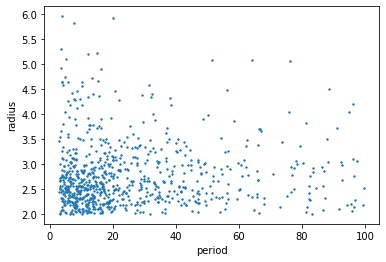

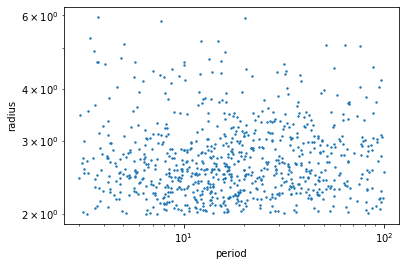

In [17]:
plt.figure()
plt.scatter(kois.koi_period, kois.corrected_prad, s=2)
#plt.ylim(0, 5)
plt.xlabel('period')
plt.ylabel('radius')

plt.figure()
plt.scatter(kois.koi_period, kois.corrected_prad, s=2)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('period')
plt.ylabel('radius')
plt.show()

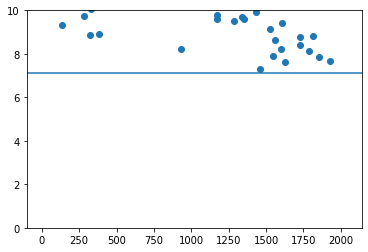

In [37]:
plt.figure()
plt.plot(kois.koi_max_mult_ev, 'o')
plt.ylim(0, 10)
plt.axhline(y=7.1)
plt.show()

802 objects


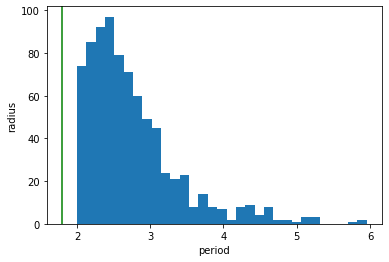

In [18]:
p = np.array(kois.koi_period.copy())
r = np.array(kois.corrected_prad.copy())

print(str(len(r)) + ' objects')
plt.figure()
c = plt.hist(r, bins=31)
plt.axvline(x=1.8, color='g')
plt.ylabel('radius')
plt.xlabel('period')
plt.show()

n = np.array(c[0])
bin_centers = np.array([0.5*(c[1][i] + c[1][i+1]) for i in range(len(c[1])-1)])

802 objects


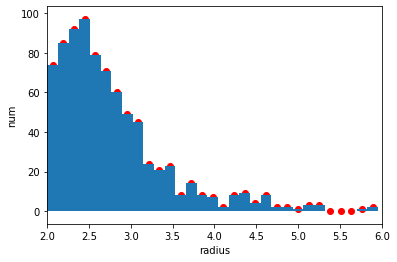

In [20]:
print(str(len(r)) + ' objects')
plt.figure()
c = plt.hist(r, bins=31)

n = np.array(c[0])
bin_centers = np.array([0.5*(c[1][i] + c[1][i+1]) for i in range(len(c[1])-1)])

plt.scatter(bin_centers, n, color='r')
plt.axvline(x=1.8, color='g')
#plt.xscale('log')
plt.xlim(2,6)
plt.ylabel('num')
plt.xlabel('radius')
plt.show()

In [21]:
print(n)
print(bin_centers)

[74. 85. 92. 97. 79. 71. 60. 49. 45. 24. 21. 23.  8. 14.  8.  7.  2.  8.
  9.  4.  8.  2.  2.  1.  3.  3.  0.  0.  0.  1.  2.]
[2.06521201 2.19272304 2.32023408 2.44774511 2.57525614 2.70276717
 2.83027821 2.95778924 3.08530027 3.21281131 3.34032234 3.46783337
 3.59534441 3.72285544 3.85036647 3.9778775  4.10538854 4.23289957
 4.3604106  4.48792164 4.61543267 4.7429437  4.87045474 4.99796577
 5.1254768  5.25298784 5.38049887 5.5080099  5.63552093 5.76303197
 5.890543  ]


[-62.93161694 239.75850606]
802 objects
[74. 85. 92. 97. 79. 71. 60. 49. 45. 24. 21. 23.  8. 14.  8.  7.  2.  8.
  9.  4.  8.  2.  2.  1.  3.  3.  0.  0.  0.  1.  2.]


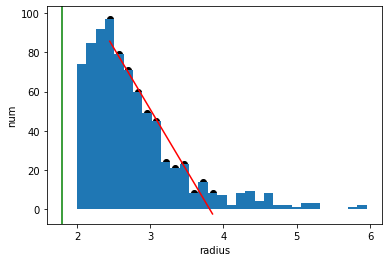

In [22]:
from scipy.optimize import curve_fit

def line(x, m, b):
    return(m*x + b)

popt, pcov = curve_fit(line, bin_centers[3:15], n[3:15])
print(popt)

print(str(len(r)) + ' objects')
plt.figure()
c = plt.hist(r, bins=31)

n = np.array(c[0])
bin_centers = np.array([0.5*(c[1][i] + c[1][i+1]) for i in range(len(c[1])-1)])
print(n)

plt.plot(bin_centers[3:15], line(bin_centers[3:15], *popt), 'r-')
plt.scatter(bin_centers[3:15], n[3:15], color='k')
plt.axvline(x=1.8, color='g')
#plt.xscale('log')
plt.ylabel('num')
plt.xlabel('radius')
plt.show()

In [ ]:
print(type(r))

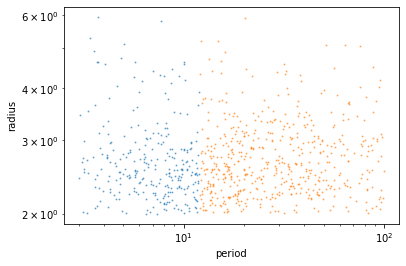

In [24]:
r2_1 = r[np.where(p <= 12)]
r2_2 = r[np.where(p > 12)]
p2_1 = p[np.where(p <= 12)]
p2_2 = p[np.where(p > 12)]

plt.figure()
plt.scatter(p2_1, r2_1, s=1, alpha=0.5)
plt.scatter(p2_2, r2_2, s=1, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('radius')
plt.xlabel('period')
plt.show()

276 objects
526 objects


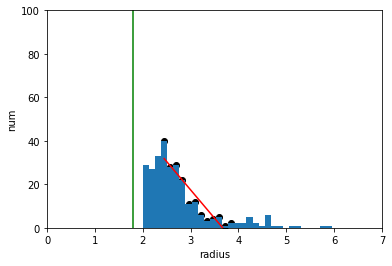

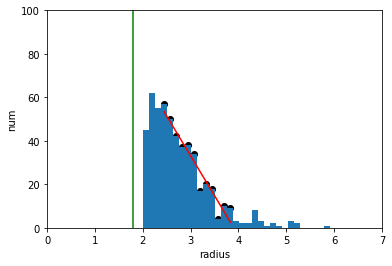

In [27]:
print(str(len(r2_1)) + ' objects')
plt.figure()
c = plt.hist(r2_1, bins=31)

n = np.array(c[0])
bin_centers = np.array([0.5*(c[1][i] + c[1][i+1]) for i in range(len(c[1])-1)])
popt, pcov = curve_fit(line, bin_centers[3:15], n[3:15])

plt.plot(bin_centers[3:15], line(bin_centers[3:15], *popt), 'r-')
plt.scatter(bin_centers[3:15], n[3:15], color='k')
plt.axvline(x=1.8, color='g')
#plt.xscale('log')
plt.xlim(0,7)
plt.ylim(0, 100)
plt.ylabel('num')
plt.xlabel('radius')

print(str(len(r2_2)) + ' objects')
plt.figure()
c = plt.hist(r2_2, bins=31)

n = np.array(c[0])
bin_centers = np.array([0.5*(c[1][i] + c[1][i+1]) for i in range(len(c[1])-1)])
popt, pcov = curve_fit(line, bin_centers[3:15], n[3:15])

plt.plot(bin_centers[3:15], line(bin_centers[3:15], *popt), 'r-')
plt.scatter(bin_centers[3:15], n[3:15], color='k')
plt.axvline(x=1.8, color='g')
#plt.xscale('log')
plt.xlim(0,7)
plt.ylim(0, 100)
plt.ylabel('num')
plt.xlabel('radius')
plt.show()

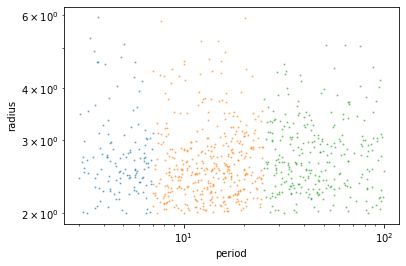

In [28]:
r3_1 = r[np.where(p <= 7)]
r3_2 = r[np.where((p > 7) & (p < 25))]
r3_3 = r[np.where(p >= 25)]
p3_1 = p[np.where(p <= 7)]
p3_2 = p[np.where((p > 7) & (p < 25))]
p3_3 = p[np.where(p >= 25)]

plt.figure()
plt.scatter(p3_1, r3_1, s=1, alpha=0.5)
plt.scatter(p3_2, r3_2, s=1, alpha=0.5)
plt.scatter(p3_3, r3_3, s=1, alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('radius')
plt.xlabel('period')
plt.show()

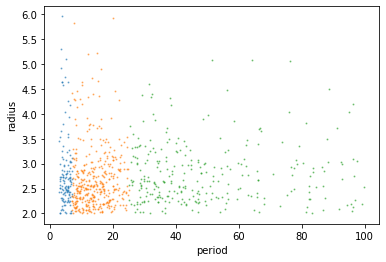

In [29]:
plt.figure()
plt.scatter(p3_1, r3_1, s=1, alpha=0.5)
plt.scatter(p3_2, r3_2, s=1, alpha=0.5)
plt.scatter(p3_3, r3_3, s=1, alpha=0.5)
plt.ylabel('radius')
plt.xlabel('period')
plt.show()

128 objects
394 objects
280 objects


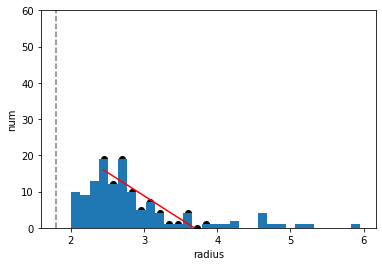

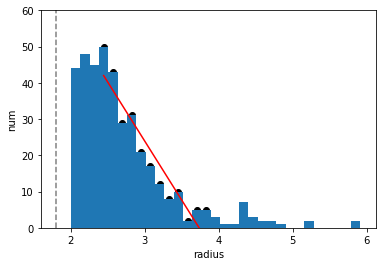

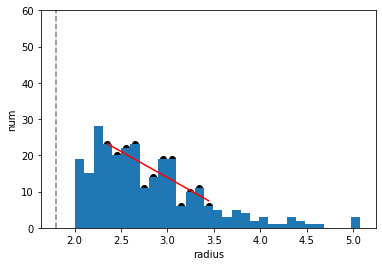

In [31]:
print(str(len(r3_1)) + ' objects')
plt.figure()
c = plt.hist(r3_1, bins=31)

n = np.array(c[0])
bin_centers = np.array([0.5*(c[1][i] + c[1][i+1]) for i in range(len(c[1])-1)])
popt, pcov = curve_fit(line, bin_centers[3:15], n[3:15])

plt.plot(bin_centers[3:15], line(bin_centers[3:15], *popt), 'r-')
plt.scatter(bin_centers[3:15], n[3:15], color='k')
plt.axvline(x=1.8, color='gray', linestyle='--')
#plt.xscale('log')
plt.ylim(0, 60)
plt.ylabel('num')
plt.xlabel('radius')

print(str(len(r3_2)) + ' objects')
plt.figure()
c = plt.hist(r3_2, bins=31)

n = np.array(c[0])
bin_centers = np.array([0.5*(c[1][i] + c[1][i+1]) for i in range(len(c[1])-1)])
popt, pcov = curve_fit(line, bin_centers[3:15], n[3:15])

plt.plot(bin_centers[3:15], line(bin_centers[3:15], *popt), 'r-')
plt.scatter(bin_centers[3:15], n[3:15], color='k')
plt.axvline(x=1.8, color='gray', linestyle='--')
#plt.xscale('log')
plt.ylim(0, 60)
plt.ylabel('num')
plt.xlabel('radius')

print(str(len(r3_3)) + ' objects')
plt.figure()
c = plt.hist(r3_3, bins=31)

n = np.array(c[0])
bin_centers = np.array([0.5*(c[1][i] + c[1][i+1]) for i in range(len(c[1])-1)])
popt, pcov = curve_fit(line, bin_centers[3:15], n[3:15])

plt.plot(bin_centers[3:15], line(bin_centers[3:15], *popt), 'r-')
plt.scatter(bin_centers[3:15], n[3:15], color='k')
plt.axvline(x=1.8, color='gray', linestyle='--')
#plt.xscale('log')
plt.ylim(0, 60)
plt.ylabel('num')
plt.xlabel('radius')
plt.show()